In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import gurobipy as gp
from gurobipy import GRB
import scipy
from ast import literal_eval
import seaborn as sns
import json
import tqdm

In [2]:
rng = np.random.default_rng(5443)

# Code to analyse 'Easy-Hard' simulated datasets

In [ ]:



# select set
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

params = params_high_revised
sc1 = axs[0].scatter(
    np.log10(params['k_tx_1']) - np.log10(params['k_deg_1']),
    np.log10(params['k_tx_2']) - np.log10(params['k_deg_2']),
    c=np.log10(params['k_reg']),
    label="Colour = log(k_reg)",
    cmap=plt.cm.plasma
)
params = params_med_revised
sc2 = axs[1].scatter(
    np.log10(params['k_tx_1']) - np.log10(params['k_deg_1']),
    np.log10(params['k_tx_2']) - np.log10(params['k_deg_2']),
    c=np.log10(params['k_reg']),
    label="Colour = log(k_reg)",
    cmap=plt.cm.plasma
)
plt.colorbar(sc1)
plt.colorbar(sc2)
axs[0].set_xlabel("log(k_tx_1 / k_deg_1)")
axs[0].set_ylabel("log(k_tx_2 / k_deg_2)")
axs[0].set_title(f"100% capture parameters")
axs[0].legend()
axs[1].set_xlabel("log(k_tx_1 / k_deg_1)")
axs[1].set_ylabel("log(k_tx_2 / k_deg_2)")
axs[1].set_title(f"50% capture parameters")
axs[1].legend()
plt.show()

# Code to analyse results of 'Easy-Hard' simulated datasets

In [92]:
def scatter_results(results_name):
    '''
    Scatter plot gene-pair parameters, coloured by result of method in detecting
    interaction (or lack of)

    results_name: suffix of dataset and results filenames in format
        (method)_(dataset type)_(capture efficiency strength)_(interaction type) 
        e.g. hyp_easy_high_noInt, min_hard_med, etc
    '''

    # identify interaction type: interaction or not
    if "noInt" in results_name:
        interaction = False
    else:
        interaction = True

    # identify method and get suffix
    if "hyp" in results_name:
        mtype = "hyp"
        suffix = results_name.replace("hyp_", "")
    elif "min" in results_name:
        mtype = "min"
        suffix = results_name.replace("min_", "")
    elif "pearson" in results_name:
        mtype="pearson"
        suffix = results_name.replace("pearson_", "")
    elif "spearman" in results_name:
        mtype="spearman"
        suffix = results_name.replace("spearman_", "")

    # read data
    params_filename = "./Datasets-Easy-Hard/params_" + suffix + ".csv"
    results_filename = "./Results-Easy-Hard/" + mtype + "_" + suffix + ".json"

    params_df = pd.read_csv(params_filename, index_col=0)
    results_dict = json.load(open(results_filename))

    # figure
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # time data
    time_data = []

    # flags for legend
    green_label_needed = True
    red_label_needed = True
    blue_label_needed = True

    # loop over each gene-pair
    for key, val in results_dict.items():

        # reset label
        label = None

        # true parameters
        params = params_df.loc[f'Gene-pair-{key}']

        # extract time
        time_data.append(val['time'])

        # decide if interaction was detected
        if mtype == "hyp":
            if val['status'] == 'INFEASIBLE':
                detected = True
            elif val['status'] == 'OPTIMAL':
                detected = False
            else:
                detected = None
        elif mtype == "min":
            if val['status'] == 'USER_OBJ_LIMIT':
                detected = True
            elif (val['status'] == 'OPTIMAL') and (val['bound'] > 0.0001) and (val['bound'] < np.inf):
                detected = True
            elif val['status'] == 'OPTIMAL':
                detected = False
            else:
                detected = None
        elif (mtype == "pearson") or (mtype == "spearman"):
            if val['pvalue'] < 0.05:
                detected = True
            elif val['pvalue'] >= 0.05:
                detected = False
            else:
                detected = None

        # set colour according to detection of interaction: data has interaction
        if interaction:
            if detected == True:
                color = "green"
                if green_label_needed:
                    label = "Interaction detected"
                    green_label_needed = False
            elif detected == False:
                color = "red"
                if red_label_needed:
                    label = "Interaction not detected"
                    red_label_needed = False
            else:
                color = "blue"
                if blue_label_needed:
                    if (mtype == "spearman") or (mtype == "pearson"):
                        label="Undefined"
                    else:
                        label="Time limit"
                    blue_label_needed = False

        # set colour according to detection of interaction: data has no interaction
        else:
            if detected == False:
                color = "green"
                if green_label_needed:
                    label = "True negative"
                    green_label_needed = False
            elif detected == True:
                color = "red"
                if red_label_needed:
                    label = "False positive"
                    red_label_needed = False
            else:
                color = "blue"
                if blue_label_needed:
                    if (mtype == "spearman") or (mtype == "pearson"):
                        label = "Undefined"
                    else:
                        label="Time limit"
                    blue_label_needed = False

        # plot point: (x, y) location as log-mean of genes, colour as detection
        axs[0].scatter(
            x = np.log10(params['k_tx_1']) - np.log10(params['k_deg_1']),
            y = np.log10(params['k_tx_2']) - np.log10(params['k_deg_2']),
            color = color,
            label = label
        )

    # format parameter scatter
    axs[0].set_xlabel("log(k_tx_1 / k_deg_1)")
    axs[0].set_ylabel("log(k_tx_2 / k_deg_2)")
    axs[0].set_title(f"Distribution of parameters and detection results for {suffix}")
    axs[0].legend()

    # format time histogram
    total_time = int(sum(time_data))
    total_time_str = f"{total_time // 3600} h {total_time // 60} m {total_time % 60}"
    axs[1].hist(time_data, label=f"Total time: " + total_time_str)
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Frequency")
    axs[1].set_title("Optimization time")
    axs[1].legend()

    # display
    plt.show()

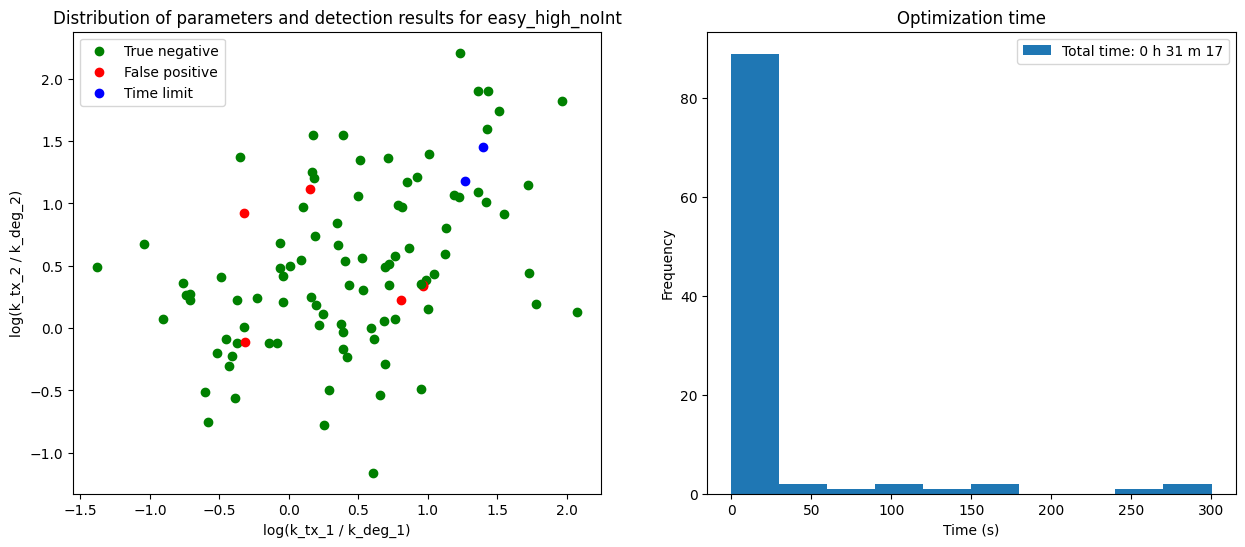

In [95]:
scatter_results("hyp_easy_high_noInt")

In [114]:
def confusion_matrix_single(results_name):
    '''
    Produce confusion matrix dictionary for a single result

    results_name: suffix of dataset and results filenames in format
        (method)_(dataset type)_(capture efficiency strength)_(interaction type) 
        e.g. hyp_easy_high_noInt, min_hard_med, etc
    '''

    # identify interaction type: interaction or not
    if "noInt" in results_name:
        interaction = False
    else:
        interaction = True

    # identify method and get suffix
    if "hyp" in results_name:
        mtype = "hyp"
        suffix = results_name.replace("hyp_", "")
    elif "min" in results_name:
        mtype = "min"
        suffix = results_name.replace("min_", "")
    elif "pearson" in results_name:
        mtype="pearson"
        suffix = results_name.replace("pearson_", "")
    elif "spearman" in results_name:
        mtype="spearman"
        suffix = results_name.replace("spearman_", "")

    # read data
    #params_filename = "./Datasets-Easy-Hard/params_" + suffix + ".csv"
    results_filename = "./Results-Easy-Hard/" + mtype + "_" + suffix + ".json"

    #params_df = pd.read_csv(params_filename, index_col=0)
    results_dict = json.load(open(results_filename))

    n = len(results_dict)

    # store classification results
    metrics = {'TP': 0, 'FP': 0, 'FN': 0, 'TN': 0}

    # loop over gene pairs
    for key, val in results_dict.items():

        # access true parameters
        # params = params_df.loc[f'Gene-pair-{key}']

        # truth
        #if (params['k_reg'] == 0):
        if not interaction:
            # negative (no interaction)
            truth = 0
        else:
            # positive (interaction)
            truth = 1

        # prediction
        if mtype == "hyp":
            if val['status'] == 'INFEASIBLE':
                # positive predicted (interaction detected)
                pred = 1
            else:
                # negative predicted (interaction not detected) [include time limit, etc.]
                pred = 0

        elif mtype == "min":
            # positive predicted (interaction detected)
            if val['status'] == 'USER_OBJ_LIMIT':
                pred = 1
            elif (val['status']== 'OPTIMAL') and (val['bound'] > 0.0001) and (val['bound'] < np.inf):
                pred = 1
            # negative predicted (interaction not detected) [include infeasible, time limit, etc.]
            else:
                pred = 0
                
        else:
            if val['pvalue'] < 0.05:
                # positive predicted (interaction detected)
                pred = 1
            else:
                # negative predicted (interaction not detected) [include nan, etc.]
                pred = 0

        
        # store result
        if truth == 1:
            if pred == 1:
                metrics['TP'] += 1 / n
            else:
                metrics['FN'] += 1 / n
        else:
            if pred == 1:
                metrics['FP'] += 1 / n
            else:
                metrics['TN'] += 1 / n

    return metrics

In [115]:
def add_metrics(metrics_1, metrics_2):
    return {key: (metrics_1[key] + metrics_2[key]) / 2 for key in ['TP', 'FP', 'FN', 'TN']}

In [116]:
def display_metrics(metrics):

    # compute measures
    try:
        accuracy = (metrics['TP'] + metrics['TN']) / (metrics['TP'] + metrics['TN'] + metrics['FP'] + metrics['FN'])
        accuracy = round(accuracy, 2)
    except:
        accuracy = "error"
    try:
        precision = metrics['TP'] / (metrics['TP'] + metrics['FP'])
        precision = round(precision, 2)
    except:
        precision = "error"
    try:
        recall = metrics['TP'] / (metrics['TP'] + metrics['FN'])
        recall = round(recall, 2)
    except:
        recall = "error"
    try:
        F1_score = 2 * (precision * recall) / (precision + recall)
        F1_score = round(F1_score, 2)
    except:
        F1_score = "error"

    # print measures
    print(f"accuracy = {accuracy}")
    print(f"precision = {precision}")
    print(f"recall = {recall}")
    print(f"F1 score = {F1_score}")

    # display confusion matrix
    values = [[metrics['TP'], metrics['FP']], [metrics['FN'], metrics['TN']]]
    confusion_matrix = pd.DataFrame(data=values, index=['Predicted Positive', 'Predicted Negative'], columns=['Positive', 'Negative'])
    cm = sns.light_palette("blue", as_cmap=True)
    return confusion_matrix.style.format(precision=2).background_gradient(cmap=cm, axis=None)

In [118]:
def classification_metrics(results_name, results_name_noInt):
    '''
    Produce and display classification metrics and confusion matrix for 
    results on an interaction and non-interaction dataset

    results_name: suffix of dataset and results filenames in format
        (method)_(dataset type)_(capture efficiency strength)_(interaction type) 
        e.g. hyp_easy_high_noInt, min_hard_med, etc
    '''

    if ("noInt" in results_name) or not ("noInt" in results_name_noInt):
        print("Wrong datasets used")
        raise Exception

    metrics = confusion_matrix_single(results_name)
    metrics_noInt = confusion_matrix_single(results_name_noInt)
    metrics_combined = add_metrics(metrics, metrics_noInt)
    return display_metrics(metrics_combined)

In [125]:
classification_metrics("hyp_easy_high", "hyp_easy_high_noInt")

accuracy = 0.69
precision = 0.88
recall = 0.43
F1 score = 0.58


,Positive,Negative
Predicted Positive,0.22,0.03
Predicted Negative,0.29,0.47


In [126]:
classification_metrics("hyp_hard_high", "hyp_hard_high_noInt")

accuracy = 0.62
precision = 0.87
recall = 0.27
F1 score = 0.41


,Positive,Negative
Predicted Positive,0.14,0.02
Predicted Negative,0.37,0.48
